In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pickle

from pathlib import Path
from tqdm.auto import tqdm

In [2]:
import sys
sys.path.append('..')

In [3]:
from lib.models import HMM, HMMFilter
from lib.policies import StaticRoutingPolicy, MinimalDelayRoutingPolicy
from lib.policies import StaticMonitoringPolicy, RecedingHorizonPolicy
from lib.simulator import Scenario, Simulator

In [4]:
# scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/2_paths/')
# scenarios_paths = [x for x in scenarios_dir.iterdir() if x.is_dir()]

In [5]:
olivier_scenarios = [
    '2_paths/Paris_Tokyo',
#     '2_paths/Boston_Tokyo'
#     '2_paths/Singapore_Moscow',
    '3_paths/Singapore_HongKong',
    '4_paths/Haifa_Santiago',
    '4_paths/Paris_Santiago'
]


scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/')
scenarios_paths = [scenarios_dir.joinpath(x) for x in olivier_scenarios]

In [6]:
benchmarks = {}

# Progress bar
p = tqdm(scenarios_paths)

series_temp={}
for scenario_path in p:
    if scenario_path!='.ipynb_checkpoints':
        scenario = Scenario.from_path(scenario_path)
        series_temp[scenario.name]=scenario.timeseries
        benchmark = {'logs': {}}

        # Constant monitoring cost
        costs = np.ones(scenario.n_paths) * 0.5

        # (Routing Policy, Monitoring Policy)
        policies = []

        # IP Path
        policies.append((
            StaticRoutingPolicy(0),
            StaticMonitoringPolicy(np.zeros(scenario.n_paths))
        ))

        # Receding Horizon
        policies.append((
            MinimalDelayRoutingPolicy(),
            RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.99, H=1, one_route=False)
        ))

        for routing_policy, monitoring_policy in policies:
            policy_name = '{} / {}'.format(routing_policy, monitoring_policy)
            p.set_description('{} ({})'.format(scenario.name, policy_name))

            try:
                sim = Simulator(scenario.timeseries, scenario.models, costs)
                benchmark['logs'][policy_name] = sim.benchmark(monitoring_policy, routing_policy)
            except Exception as e:
                print('Failed to simulate {}'.format(policy_name))
                print(e)

        benchmarks[scenario.name] = benchmark


In [11]:
infile = open('DatosH4_oneroute.pickle','rb')
benchmarks = pickle.load(infile)
infile.close()
#print(new_dict)

In [7]:
# print(scenario.models)
# print(sim.timeseries)
for scenario, benchmark in benchmarks.items():
    print(scenario)
#     print(benchmark['logs'].items())
    for policy, log in benchmark['logs'].items():
        gap=0
        no_min=0
        delay=log.get('delay')
        minimo=[]
#         minimo=delay
#         print(minimo)
        for i in range(len(delay)):
            menor=False
            minimo.append(delay[i])
            for j in range(len(series_temp[scenario])):
                if delay[i]>series_temp[scenario][j][i]:
                    menor=True
                    minimo[i]=series_temp[scenario][j][i]
            gap+=(delay[i]-minimo[i])/minimo[i]
            if menor==True:
                no_min+=1
        print(policy, 1-no_min*1./len(delay), gap*1./len(delay))

Paris_Tokyo
Static Route 0 / Never Measure 0.6810951760104302 0.0030903699364293806
Minimal Delay / RH(ρ=0.99,H=1) 0.8083441981747066 0.0021790015708144524
Singapore_HongKong
Static Route 0 / Never Measure 0.850586701434159 0.05486506617230752
Minimal Delay / RH(ρ=0.99,H=1) 0.9791395045632334 0.008284890950041849
Haifa_Santiago
Static Route 0 / Never Measure 0.3421121251629726 0.012757710895795698
Minimal Delay / RH(ρ=0.99,H=1) 0.8597131681877445 0.0029978506144265724
Paris_Santiago
Static Route 0 / Never Measure 0.678748370273794 0.012510760192306309
Minimal Delay / RH(ρ=0.99,H=1) 0.9361147327249022 0.0015086624646100657


In [8]:
def get_benchmark_df(benchmarks):
    records = []

    for scenario, benchmark in benchmarks.items():
        for policy, log in benchmark['logs'].items():
            records.append({
                'scenario': scenario,
                'policy': policy,
                'avg_delay': log.avg_delay(),
                'avg_cost': log.avg_cost(),
                'avg_processing_time': log.avg_processing_time() / 1e3,
                'avg_n_measures': log.avg_n_measures()
            })

    return pd.DataFrame.from_records(records)

In [9]:
get_benchmark_df(benchmarks)

,avg_cost,avg_delay,avg_n_measures,avg_processing_time,policy,scenario
0,0.000000,248.308882,0.000000,2.300524,Static Route 0 / Never Measure,Paris_Tokyo
1,0.001173,248.084757,0.002347,2002.525937,"Minimal Delay / RH(ρ=0.99,H=1)",Paris_Tokyo
2,0.000000,63.244123,0.000000,2.678180,Static Route 0 / Never Measure,Singapore_HongKong
3,0.215124,55.096169,0.430248,5084.270953,"Minimal Delay / RH(ρ=0.99,H=1)",Singapore_HongKong
4,0.000000,301.964132,0.000000,3.140869,Static Route 0 / Never Measure,Haifa_Santiago
5,0.062060,297.126341,0.124120,11048.256790,"Minimal Delay / RH(ρ=0.99,H=1)",Haifa_Santiago
6,0.000000,248.410657,0.000000,3.011716,Static Route 0 / Never Measure,Paris_Santiago
7,0.025684,243.290065,0.051369,16650.603491,"Minimal Delay / RH(ρ=0.99,H=1)",Paris_Santiago


Paris_Tokyo
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fe97db5f810>, 'Minimal Delay / RH(ρ=0.99,H=1)': <lib.simulator.Logbook object at 0x7fe97d8886d0>}}
Singapore_HongKong
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fe97c83ce50>, 'Minimal Delay / RH(ρ=0.99,H=1)': <lib.simulator.Logbook object at 0x7fe97c1d5c10>}}
Haifa_Santiago
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fe97c488d50>, 'Minimal Delay / RH(ρ=0.99,H=1)': <lib.simulator.Logbook object at 0x7fe97c26c250>}}
Paris_Santiago
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fe97c4dce50>, 'Minimal Delay / RH(ρ=0.99,H=1)': <lib.simulator.Logbook object at 0x7fe97c4dc710>}}


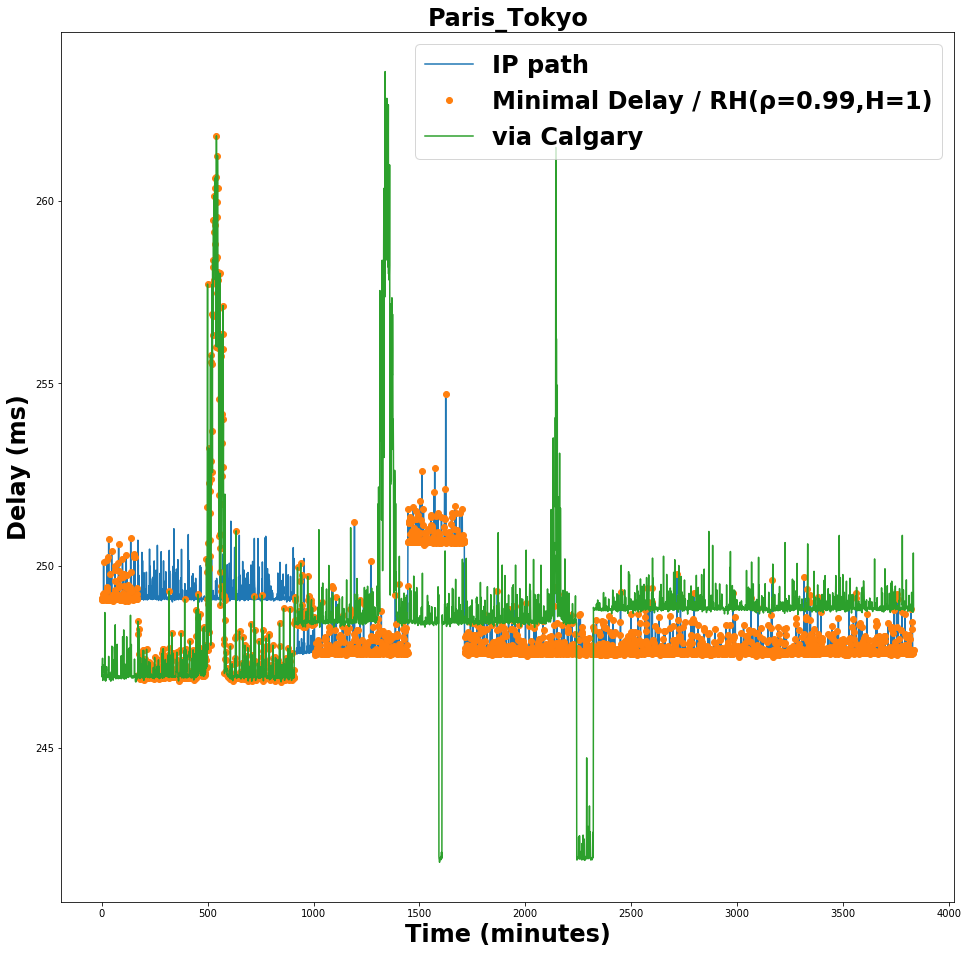

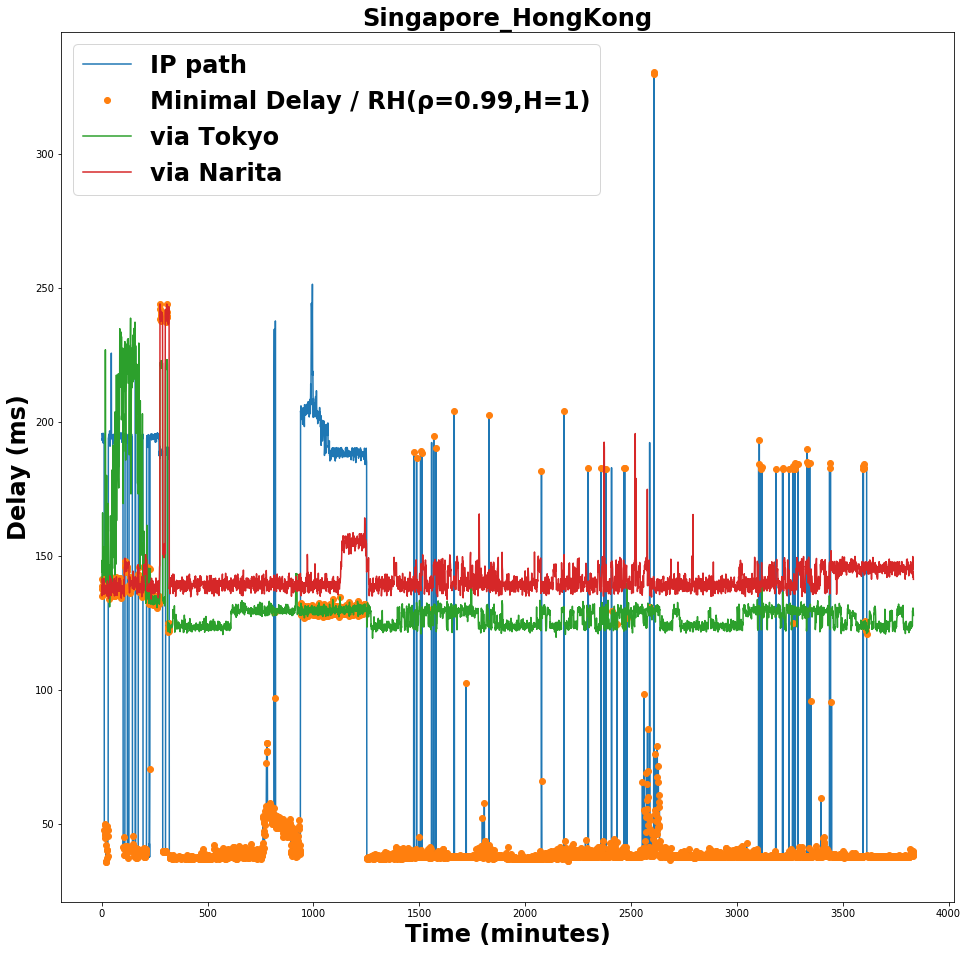

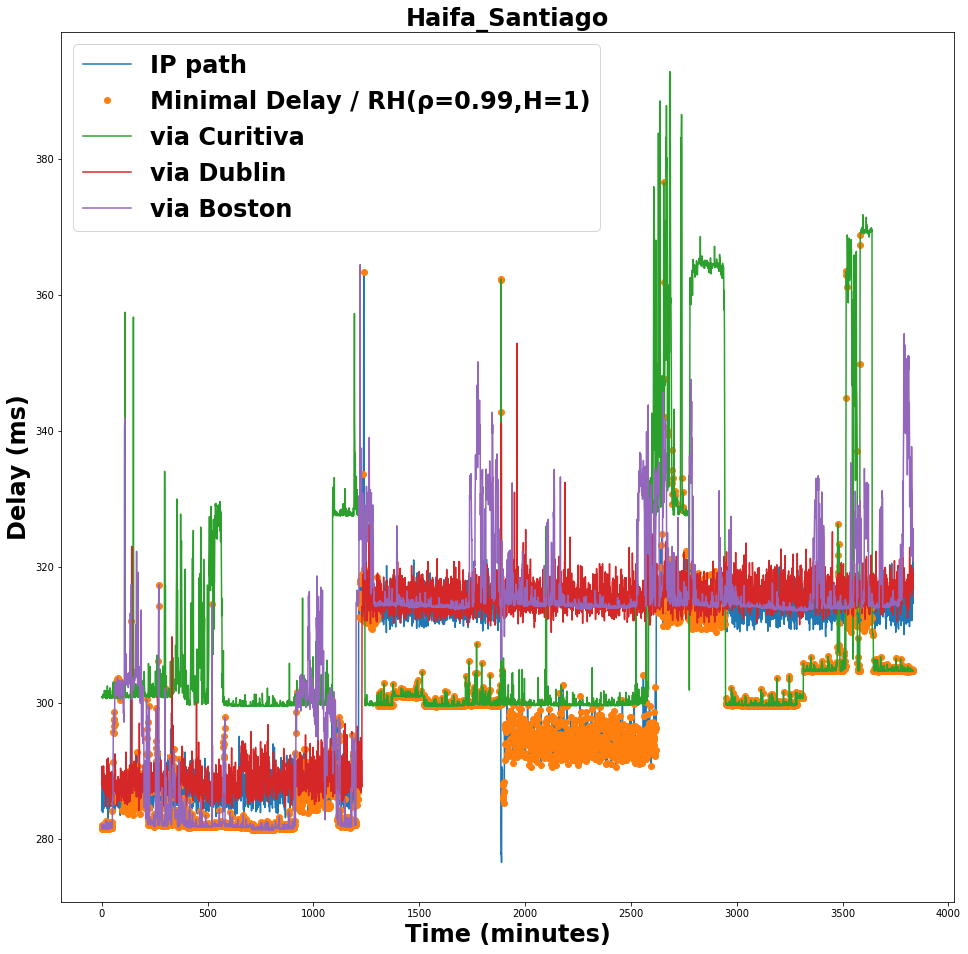

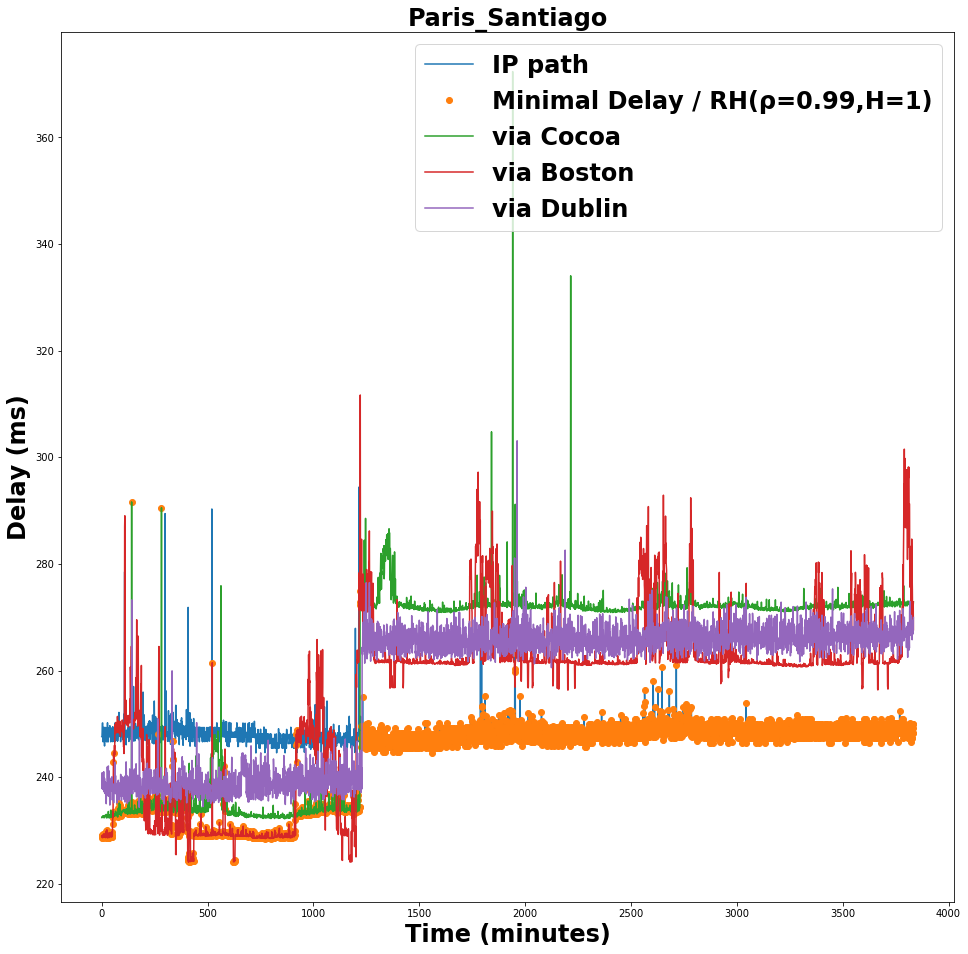

In [7]:
# print(scenario.models)
# print(sim.timeseries)
legend_properties = {'weight':'bold', 'size':'24'}
proxies={'Paris_Tokyo': ['IP path', 'via Calgary'], 'Singapore_Moscow': ['IP path', 'via Gibraltar'], 'Singapore_HongKong': ['IP path', 'via Tokyo', 'via Narita'], 'Haifa_Santiago': ['IP path', 'via Curitiva', 'via Dublin', 'via Boston'], 'Paris_Santiago': ['IP path', 'via Cocoa', 'via Boston', 'via Dublin']}
for scenario, benchmark in benchmarks.items():
    print(scenario)
    print(benchmark)
    fig=plt.figure(figsize=(16,16))
    ax=fig.add_subplot(1,1,1)
    for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
        if policy=='Static Route 0 / Never Measure':
            ax.plot(log.get('delay'), label='IP path')
        else:
            ax.plot(log.get('delay'), 'o', label=policy)
    for paths in range(1, len(proxies[scenario])):
        ax.plot(series_temp[scenario][paths], label=proxies[scenario][paths])
    ax.set_xlabel('Time (minutes)', fontsize=24, weight='bold')
    ax.set_ylabel('Delay (ms)', fontsize=24, weight='bold')
    ax.set_title(str(scenario), fontsize=24, weight='bold')
    plt.legend(prop=legend_properties)
    plt.savefig('Delay'+str(scenario)+'.pdf')
#     plt.show()

In [9]:
import pickle
filename = 'Datos2Rutas'
outfile = open(filename,'wb')
pickle.dump(benchmarks,outfile)
outfile.close()

In [12]:
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
print(new_dict)

{'Haifa_Santiago': {'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fc53c1a3590>, 'Minimal Delay / RH(ρ=0.99,H=3)': <lib.simulator.Logbook object at 0x7fc535f1aa10>}}}


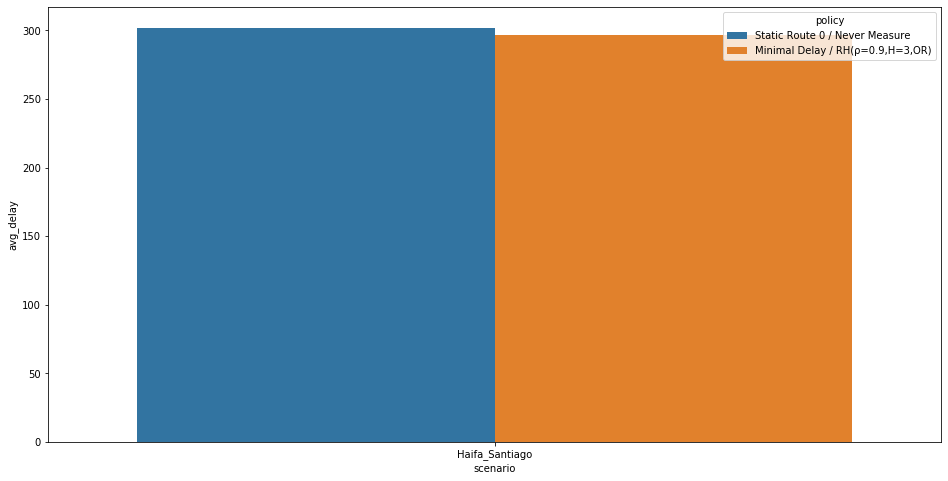

In [60]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_delay', hue='policy', data=df)
# plt.savefig('../figures/benchmark_delay_v2.png', bbox_inches='tight', dpi=300)

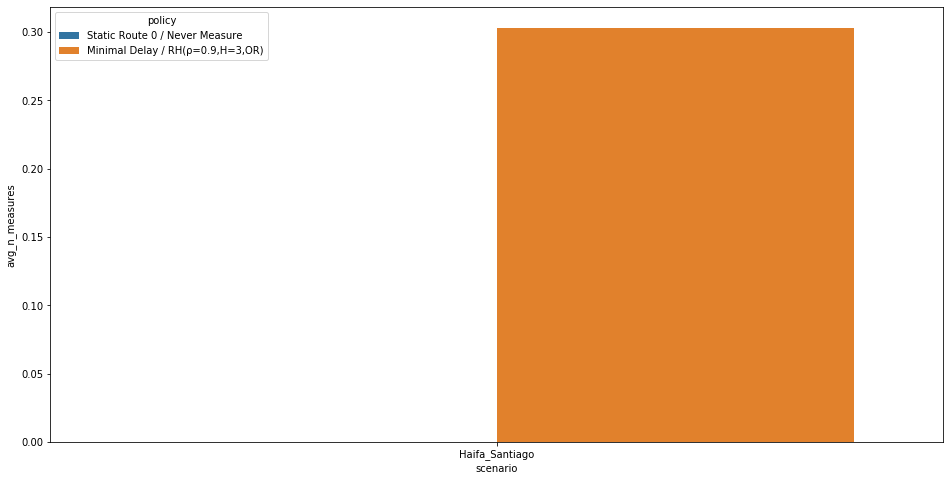

In [61]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_n_measures', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

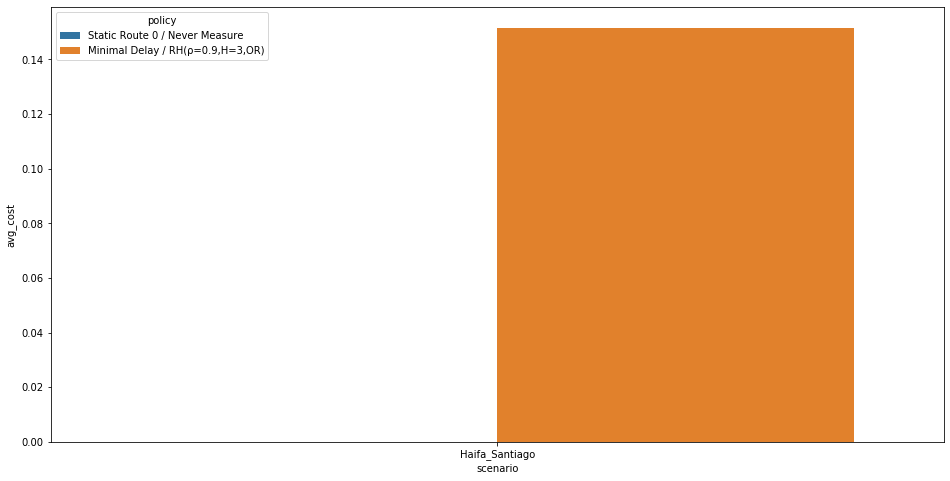

In [62]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_cost', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

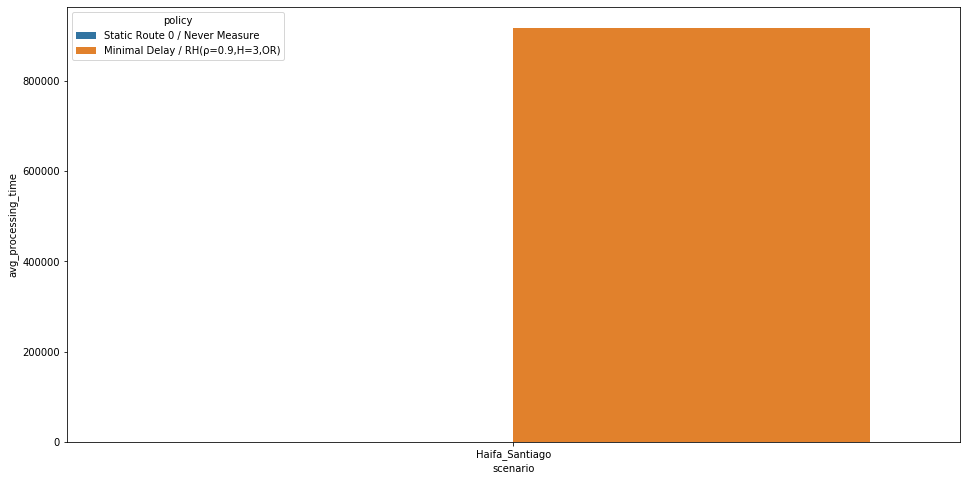

In [63]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_processing_time', hue='policy', data=df)
# plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)